# import libraries & settings

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set_theme(color_codes=True)

import warnings

warnings.filterwarnings(action="ignore")

import sys

sys.path.append("/opt/ml/input/code/")
import feature_engineering as fe

path = "/opt/ml/input/data/"
dtype = {"userID": "int16", "answerCode": "int8", "KnowledgeTag": "int16"}

train = pd.read_csv(path + "train_data.csv", dtype=dtype)
test = pd.read_csv(path + "test_data.csv", dtype=dtype)
train = train.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)
test = test.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)

In [ ]:
print(len(train))
print(len(test))

In [ ]:
train_set = set(train["userID"])
test_set = set(test["userID"])
train_test_set = set(train_set - test_set)
print(len(train_set))
print(len(test_set))
print(len(train_test_set))

* train: 220만개의 row, 6698명의 유저
* test: 26만개의 row, 744명의 유저
* train과 test 간 같은 유저 존재하지 않음

In [38]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [39]:
train_answer_rate = train.groupby("answerCode").count() / len(train)
test_answer_rate = test.groupby("answerCode").count() / len(test)
print(train_answer_rate["userID"])
print(test_answer_rate["userID"])

answerCode
0    0.345622
1    0.654378
Name: userID, dtype: float64
answerCode
-1    0.002860
 0    0.342108
 1    0.655032
Name: userID, dtype: float64


* train/test 정답률: 약 65.5%

In [40]:
def percentile(s):
    return np.sum(s) / len(s)

# Preprocess

In [41]:
train = fe.feature_engineering(train)

In [ ]:
train

In [43]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'userID_answerCode_mean', 'userID_answerCode_count',
       'userID_answerCode_sum', 'userID_answerCode_var',
       'userID_answerCode_median', 'testId_answerCode_mean',
       'testId_answerCode_count', 'testId_answerCode_sum',
       'testId_answerCode_var', 'testId_answerCode_median',
       'assessmentItemID_answerCode_mean', 'assessmentItemID_answerCode_count',
       'assessmentItemID_answerCode_sum', 'assessmentItemID_answerCode_var',
       'assessmentItemID_answerCode_median', 'KnowledgeTag_answerCode_mean',
       'KnowledgeTag_answerCode_count', 'KnowledgeTag_answerCode_sum',
       'KnowledgeTag_answerCode_var', 'KnowledgeTag_answerCode_median', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'dayofweek',
       'dayofweek_answerCode_mean', 'dayofweek_answerCode_count',
       'dayofweek_answerCode_sum', 'dayofweek_answerCode_var',
       'dayofweek_answerCode_median

# Timestamp EDA

In [44]:
train["Timestamp"] = pd.to_datetime(train["Timestamp"])
train["Timestamp"].dtype

dtype('<M8[ns]')

## year

In [45]:
year = train.groupby(train["Timestamp"].dt.year).agg({"assessmentItemID": "count"})
year

,assessmentItemID
Timestamp,
2019,19
2020,2266567


* year 데이터는 무시해도 될 것 같음

## month

In [46]:
month = train.groupby(train["Timestamp"].dt.month).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)
month

,assessmentItemID,answerCode
Timestamp,,
1,37387,0.712199
2,79478,0.687222
3,174482,0.682643
4,176953,0.649545
5,183816,0.643317
6,227481,0.651967
7,270597,0.665650
8,316115,0.657599
9,339265,0.668872


* 월 별 문제 풀이 건수의 차이가 있다
* 월 별 정답률에 차이가 있다
* 월 별 정답률은 'month_answerCode_mean'에 처리되어있음

## day

In [47]:
day = train.groupby(train["Timestamp"].dt.day).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)
day

,assessmentItemID,answerCode
Timestamp,,
1,54381,0.652507
2,62414,0.656055
3,71031,0.653433
4,66610,0.644408
5,59781,0.642880
6,72464,0.666662
7,78627,0.661618
8,74072,0.660020
9,68321,0.657514


* 일자별 정답률의 유의미한 차이는 없는것 같다
* 월초보다 월말에 문제 풀이 건수가 많은것 같다
* 합산 집계이므로 31일은 문제 풀이 수가 적음

In [48]:
weekday = train.groupby(train["Timestamp"].dt.weekday).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

* 0: 월요일, 6: 일요일
* 일별 정답률의 차이가 보인다

# hour

In [49]:
hour = train.groupby(train["Timestamp"].dt.hour).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)
hour

,assessmentItemID,answerCode
Timestamp,,
0,101137,0.649446
1,136702,0.644321
2,156892,0.642410
3,141911,0.632685
4,148677,0.633292
5,163289,0.624776
6,167792,0.629941
7,166396,0.643050
8,157963,0.667948


* 새벽과 아침에 문제를 많이 풀고, 낮과 저녁에 문제를 적게 푸는 데이터가 보인다
* 일반적인 직관과 괴리가 크다. 시간대가 밀린 것이 아닐까 싶다
* 시간대별 정답률이 큰 차이를 보인다

# Timestamp Feature Engineering

## 1. 유저의 문항 풀이 시간

In [50]:
train["elapsedTime"] = pd.to_timedelta(train["Timestamp"] - train["Timestamp"].shift(1))
train["elapsedTime"] = train["elapsedTime"].dt.total_seconds()
train["elapsedTime"].head()

0    NaN
1    3.0
2    8.0
3    7.0
4    7.0
Name: elapsedTime, dtype: float64

In [51]:
minus_index = train["elapsedTime"] < 0
train.loc[minus_index, "elapsedTime"] = np.nan

In [52]:
train["elapsedTime"].describe()

count    2.259937e+06
mean     5.290012e+04
std      4.056418e+05
min      0.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      1.360000e+02
max      2.560230e+07
Name: elapsedTime, dtype: float64

In [53]:
out_of_75_index = train["elapsedTime"] > 136
train.loc[out_of_75_index, "elapsedTime"] = np.nan

In [54]:
nan = train["elapsedTime"].isnull()
train.loc[nan, "elapsedTime"] = train["elapsedTime"].mean()

<AxesSubplot: >

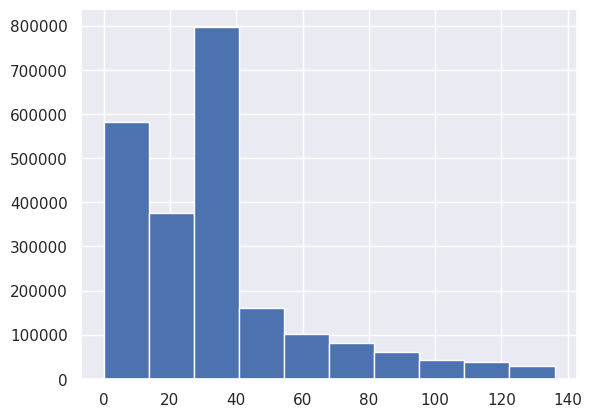

In [55]:
train["elapsedTime"].hist()

## 2. 유저 별 문제 풀이 시간의 중간값

In [56]:
agg_df = train.groupby("userID")["elapsedTime"].agg(["median"])
agg_df.head(20)
# agg_dict = agg_df.to_dict()
# train['userID_elapsedTime_median'] = train['userID'].map(agg_dict['median'])
# train[['userID', 'userID_elapsedTime_median']].groupby('userID')['userID_elapsedTime_median'].agg(['median'])

,median
userID,
0,27.000000
1,32.976259
2,32.976259
5,32.976259
6,26.000000
7,32.976259
8,32.976259
9,32.976259
10,32.976259


In [57]:
agg_df = train.groupby(["userID", "answerCode"])["elapsedTime"].agg(["median"])  # mean
agg_df.head(20)
# agg_dict = agg_df.to_dict()
# train['userID_elapsedTime_median'] = train['userID'].map(agg_dict['median'])
# train[['userID', 'userID_elapsedTime_median']].groupby('userID')['userID_elapsedTime_median'].agg(['median'])

median
userID answerCode           
0      0           16.000000
       1           31.500000
1      0           32.976259
       1           32.976259
2      0            6.000000
       1           32.976259
5      0           32.976259
       1           32.976259
6      0           11.000000
       1           32.976259
7      0            5.000000
       1           32.976259
8      0           30.500000
       1           32.976259
9      0           32.976259
       1           32.976259
10     0           32.976259
       1           32.976259
11     0            4.000000
       1           32.976259

## 3. 태그 별 풀이 시간의 중간값

In [58]:
agg_df = train.groupby("KnowledgeTag")["elapsedTime"].agg(["median"])
agg_df.head(20)
# agg_dict = agg_df.to_dict()
# train['KnowledgeTag_elapsedTime_median'] = train['KnowledgeTag'].map(agg_dict['median'])
# train[['KnowledgeTag', 'KnowledgeTag_elapsedTime_median']].groupby('KnowledgeTag')['KnowledgeTag_elapsedTime_median'].agg(['median'])

,median
KnowledgeTag,
23,23.000000
24,32.976259
25,29.500000
26,26.000000
30,20.000000
31,32.976259
32,18.000000
78,16.000000
116,18.000000


In [59]:
agg_df = train.groupby(["KnowledgeTag", "answerCode"])["elapsedTime"].agg(["median"])
agg_df.head(20)

median
KnowledgeTag answerCode           
23           0            3.000000
             1           32.976259
24           0           32.976259
             1           32.976259
25           0            3.000000
             1           32.976259
26           0            5.000000
             1           32.976259
30           0            3.000000
             1           32.976259
31           0           19.500000
             1           32.976259
32           0            4.000000
             1           32.976259
78           0            4.000000
             1           24.000000
116          0           11.000000
             1           25.000000
117          0           14.000000
             1           32.976259

## 4. 문항 별 풀이 시간의 중간값

In [60]:
agg_df = train.groupby("assessmentItemID")["elapsedTime"].agg(["median"])
agg_df.head(20)
# agg_dict = agg_df.to_dict()
# train['assessmentItemID_elapsedTime_median'] = train['assessmentItemID'].map(agg_dict['median'])
# train[['assessmentItemID', 'assessmentItemID_elapsedTime_median']].groupby('assessmentItemID')['assessmentItemID_elapsedTime_median'].agg(['median'])

,median
assessmentItemID,
A010001001,32.976259
A010001002,18.000000
A010001003,12.000000
A010001004,29.000000
A010001005,35.000000
A010002001,32.976259
A010002002,32.000000
A010002003,11.000000
A010002004,12.000000


In [61]:
agg_df = train.groupby(["assessmentItemID", "answerCode"])["elapsedTime"].agg(
    ["median"]
)
agg_df.head(20)

median
assessmentItemID answerCode           
A010001001       0           32.976259
                 1           32.976259
A010001002       0           32.000000
                 1           18.000000
A010001003       0           17.500000
                 1           12.000000
A010001004       0           31.988129
                 1           29.000000
A010001005       0           37.000000
                 1           35.000000
A010002001       0           32.976259
                 1           32.976259
A010002002       0           28.988129
                 1           32.000000
A010002003       0           11.000000
                 1           11.000000
A010002004       0           10.000000
                 1           12.000000
A010002005       0           27.000000
                 1           31.000000

## 5. 시험 별 풀이 시간의 중간값

In [62]:
agg_df = train.groupby("testId")["elapsedTime"].agg(["median"])
agg_df.head(20)
# agg_dict = agg_df.to_dict()
# train['testId_elapsedTime_median'] = train['testId'].map(agg_dict['median'])
# train[['testId', 'testId_elapsedTime_median']].groupby('testId')['testId_elapsedTime_median'].agg(['median'])

,median
testId,
A010000001,29.000000
A010000002,26.000000
A010000003,29.000000
A010000004,22.000000
A010000005,32.000000
A010000006,32.976259
A010000007,32.976259
A010000008,32.000000
A010000009,32.976259


In [63]:
agg_df = train.groupby(["testId", "answerCode"])["elapsedTime"].agg(["median"])
agg_df.head(20)

median
testId     answerCode           
A010000001 0           32.976259
           1           29.000000
A010000002 0           25.500000
           1           26.000000
A010000003 0           32.000000
           1           28.000000
A010000004 0           32.000000
           1           20.000000
A010000005 0           27.000000
           1           32.976259
A010000006 0           31.000000
           1           32.976259
A010000007 0           32.976259
           1           32.976259
A010000008 0           32.000000
           1           31.000000
A010000009 0           32.976259
           1           32.976259
A010000010 0           27.000000
           1           32.976259

## 6. first3 별 문항 풀이 시간의 중간값

In [64]:
agg_df = train.groupby("first3")["elapsedTime"].agg(["median"])
agg_df.head(20)
# agg_dict = agg_df.to_dict()
# train['first3_elapsedTime_median'] = train['first3'].map(agg_dict['median'])
# train[['first3', 'first3_elapsedTime_median']].groupby('first3')['first3_elapsedTime_median'].agg(['median'])

,median
first3,
010,32.976259
020,32.976259
030,32.976259
040,32.976259
050,32.976259
060,32.976259
070,25.000000
080,17.000000
090,11.000000


* 6번 feature는 변별력이 부족할 것으로 보임

## 7. 유저 별 first3에 대한 평균 문항 풀이 시간

In [65]:
agg_df = train.groupby(["userID", "first3", "answerCode"])["elapsedTime"].agg(
    ["median"]
)
agg_df.columns = ["userID_first3_answerCode_median"]
agg_df.head(20)

userID_first3_answerCode_median
userID first3 answerCode                                 
0      020    0                                 38.000000
              1                                 32.976259
       060    0                                 31.000000
              1                                 25.500000
       080    0                                  5.000000
              1                                 32.976259
1      040    0                                 32.976259
              1                                 32.976259
       090    0                                 32.976259
              1                                 35.500000
2      030    0                                 47.500000
              1                                 32.976259
       050    0                                  4.000000
              1                                 12.000000
5      010    0                                 32.976259
              1                                 32.976259
       060    0                                 37.000000
              1                                 32.976259
       080    0                                 32.976259
              1                                 32.976259

In [66]:
pd.merge(left=train, right=agg_df, how="left", on=["userID", "first3", "answerCode"])

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,userID_answerCode_mean,userID_answerCode_count,userID_answerCode_sum,userID_answerCode_var,...,hour_answerCode_var,hour_answerCode_median,hour_answerCode_Level,month_answerCode_mean,month_answerCode_count,month_answerCode_sum,month_answerCode_var,month_answerCode_median,elapsedTime,userID_first3_answerCode_median_y
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,745,470,0.233185,...,0.227668,1.0,1,0.682643,174482,119109,0.216643,1.0,32.976259,25.500000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,745,470,0.233185,...,0.227668,1.0,1,0.682643,174482,119109,0.216643,1.0,3.000000,25.500000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,745,470,0.233185,...,0.227668,1.0,1,0.682643,174482,119109,0.216643,1.0,8.000000,25.500000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,745,470,0.233185,...,0.227668,1.0,1,0.682643,174482,119109,0.216643,1.0,7.000000,25.500000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,745,470,0.233185,...,0.227668,1.0,1,0.682643,174482,119109,0.216643,1.0,7.000000,25.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,9,5,0.277778,...,0.233117,1.0,0,0.651967,227481,148310,0.226907,1.0,24.000000,33.488129
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,9,5,0.277778,...,0.229173,1.0,1,0.657599,316115,207877,0.225163,1.0,32.976259,39.488129
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,9,5,0.277778,...,0.229173,1.0,1,0.657599,316115,207877,0.225163,1.0,11.000000,39.488129
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,9,5,0.277778,...,0.229173,1.0,1,0.657599,316115,207877,0.225163,1.0,46.000000,39.488129
